In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pytz import timezone
import json
from datetime import datetime

In [6]:
with open('C:\\Users\\nithy\\NK\\UCD\\Sem3\\SustainbleCityAI\\Backend\\plot_intensity\\co2_intensity_all_2025-06-01_2025-06-30.json', 'r') as file:
                json_data = json.load(file)

time_series = json_data['data']['time_series']
df = pd.DataFrame(time_series)

# Convert to datetime - adjust format as needed based on your actual data
df['timestamp'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

# Ensure timestamps are timezone-aware (Europe/Dublin)
if df['timestamp'].dt.tz is None:
    ireland = timezone('Europe/Dublin')
    df['timestamp'] = df['timestamp'].dt.tz_localize(ireland)

# Filter to only include future values from current time
# now = pd.Timestamp.now(tz= ireland)  # Use pandas Timestamp for consistent comparison
# df = df[df['timestamp'] >= now].copy()

df.set_index('timestamp', inplace=True)

# Aggregate to hourly mean 
data_daily = df['value'].resample('d').mean()


In [7]:
data_daily= data_daily.reset_index()

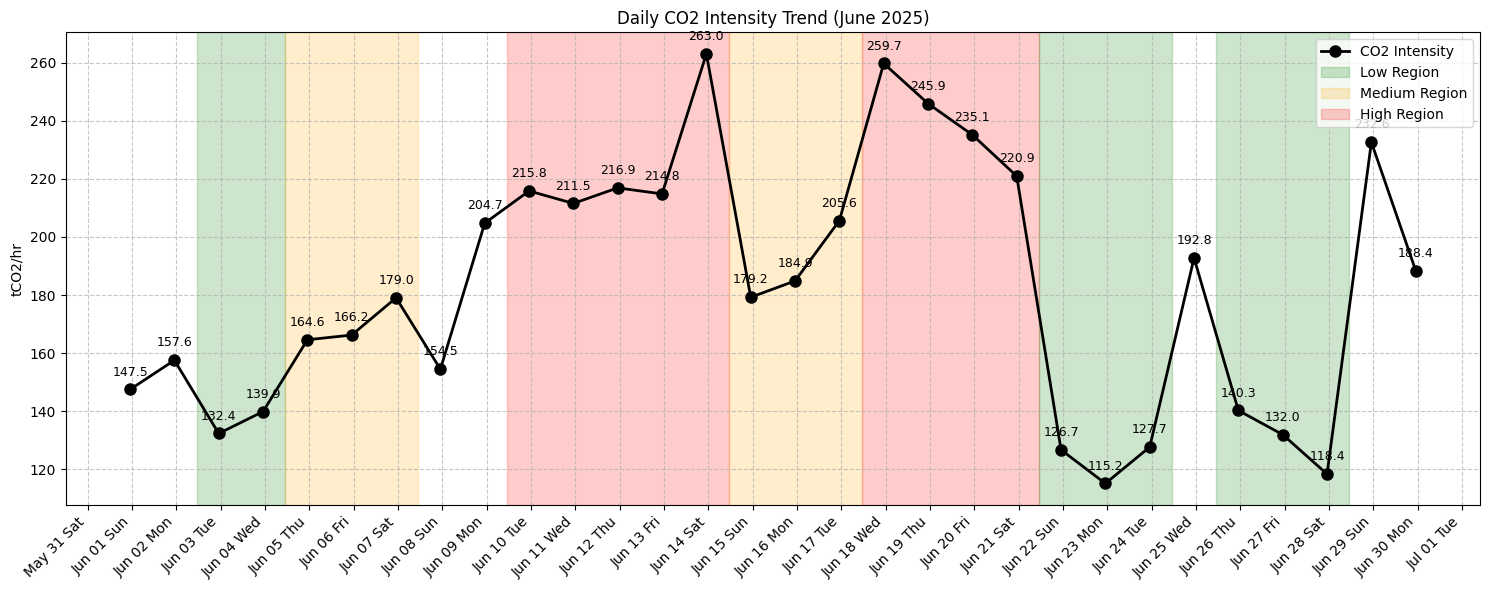

In [ ]:
def highlight_long_continuous_periods(df_):
    """Highlights contiguous low/medium/high intensity regions lasting >N days."""
    
    df = df_.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.sort_values("timestamp", inplace=True)

    # Normalize the data using Min-Max scaling
    min_val = df["value"].min()
    max_val = df["value"].max()
    df["normalized_value"] = (df["value"] - min_val) / (max_val - min_val)

    # Compute thresholds on normalized data
    p33 = np.percentile(df["normalized_value"], 33)
    p66 = np.percentile(df["normalized_value"], 66)

    # Categorize function
    def categorize(val):
        if val <= p33:
            return "Low"
        elif val <= p66:
            return "Medium"
        else:
            return "High"

    df["category"] = df["normalized_value"].apply(categorize)

    # Identify consecutive groups with same category
    df["group"] = (df["category"] != df["category"].shift()).cumsum()

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(df["timestamp"], df["value"], color="black", 
            linewidth=2, marker='o', markersize=8, label="CO2 Intensity")

    # Color map for categories
    color_map = {"Low": "green", "Medium": "orange", "High": "red"}
    added_to_legend = set()

    # Loop over groups (checking for consecutive days)
    for _, group_df in df.groupby("group"):
        category = group_df["category"].iloc[0]
        start_time = group_df["timestamp"].iloc[0]
        end_time = group_df["timestamp"].iloc[-1]
        duration_days = (end_time - start_time).days + 1  # +1 to include both start and end
        
        # Highlight regions lasting at least 2 consecutive days (adjust as needed)
        if duration_days >= 2:
            label = f"{category} Region" if category not in added_to_legend else None
            ax.axvspan(start_time - pd.Timedelta(hours=12),  # Center the highlight
                      end_time + pd.Timedelta(hours=12),
                      color=color_map[category], alpha=0.2, label=label)
            if label:
                added_to_legend.add(category)

    # Format x-axis for daily data
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every day
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d %a"))  # "Jun 01" format
    
    # Rotate and align x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Add value annotations
    for x, y in zip(df["timestamp"], df["value"]):
        ax.annotate(f"{y:.1f}", (x, y), textcoords="offset points", 
                   xytext=(0,10), ha='center', fontsize=9)

    ax.set_ylabel("tCO2/hr")
    ax.set_title("Daily CO2 Intensity Trend (June 2025)")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Call the function
highlight_long_continuous_periods(data_daily)

In [59]:
from statsmodels.tsa.seasonal import STL

C:\Users\nithy\AppData\Local\Temp\ipykernel_20368\2803060681.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = df['value'].resample('H').mean()


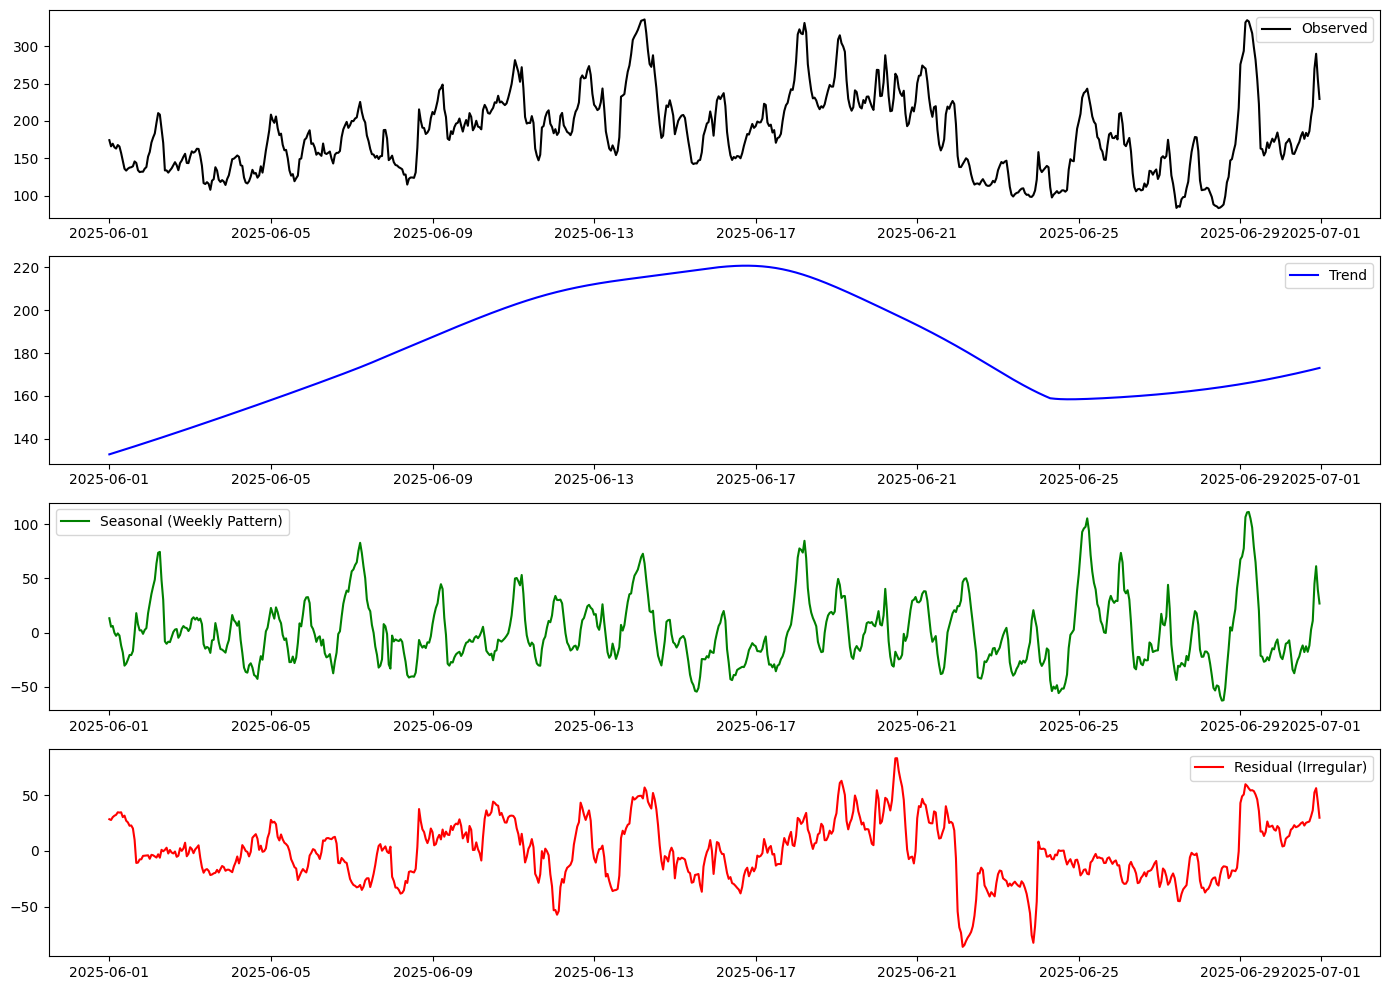

High      245
Low       238
Medium    237
Name: count, dtype: int64


In [ ]:
# Convert to DataFrame
time_series = json_data['data']['time_series']
df = pd.DataFrame(time_series)

# Convert to datetime
df['timestamp'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

# Localize to Europe/Dublin timezone
ireland = timezone('Europe/Dublin')
if df['timestamp'].dt.tz is None:
    df['timestamp'] = df['timestamp'].dt.tz_localize(ireland)

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Aggregate to hourly mean
data_hourly = df['value'].resample('H').mean()

# STL decomposition with weekly seasonality (7 days * 24 hours = 168)
stl = STL(data_hourly, period=168)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Optional: Classify residuals into Low, Medium, High
low_threshold = np.percentile(residual, 33)
high_threshold = np.percentile(residual, 66)

# Create new column for segmentation
segmentation = pd.Series(np.select(
    [residual <= low_threshold,
     (residual > low_threshold) & (residual <= high_threshold),
     residual > high_threshold],
    ['Low', 'Medium', 'High'],
    default='Unknown'  # Ensure all outputs are strings
), index=residual.index)


# Visualize components
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(data_hourly, label='Observed', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal (Weekly Pattern)', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual (Irregular)', color='red')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Print counts for Low/Medium/High periods
print(segmentation.value_counts())

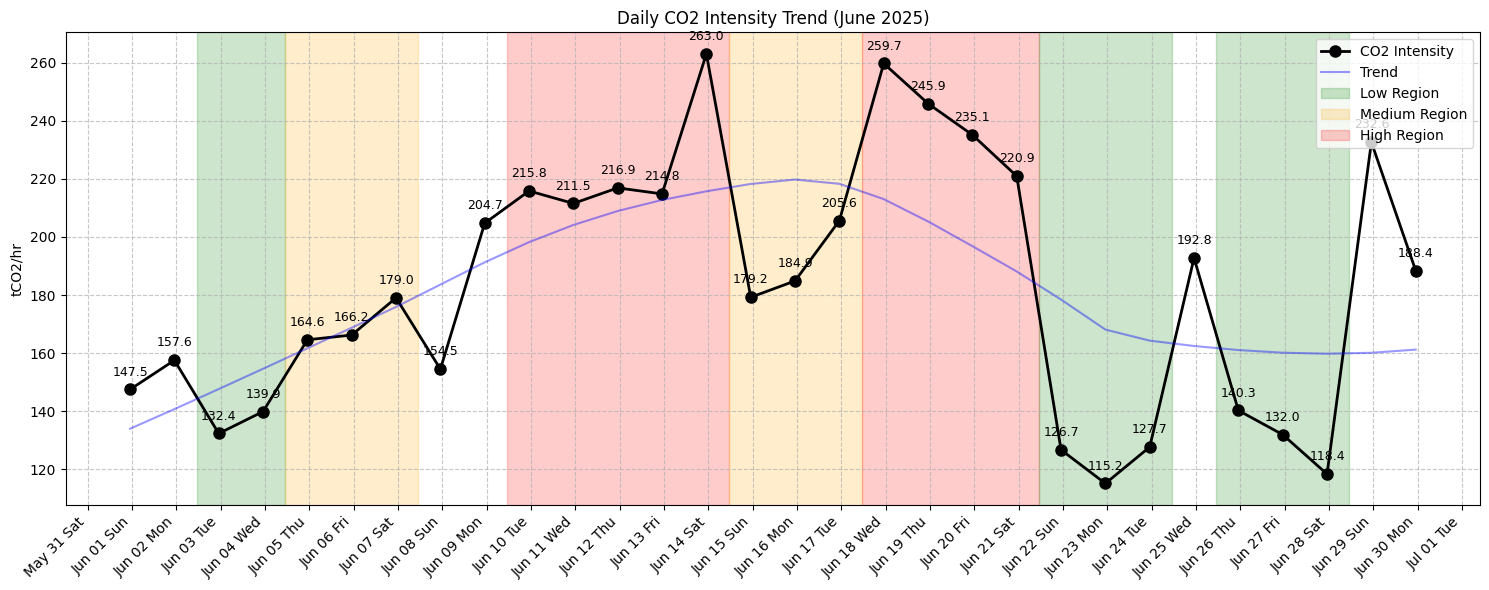

In [78]:
def highlight_long_continuous_periods(df_):
    """Highlights contiguous low/medium/high intensity regions lasting >N days."""
    
    df = df_.copy()

    # Convert timestamp and sort
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.sort_values("timestamp", inplace=True)

    # STL decomposition requires a Series with datetime index and numeric values
    # Create a Series with timestamp as index and value as data
    ts = df.set_index("timestamp")["value"]
    
    # Perform STL decomposition (period=168 for weekly seasonality in hourly data)
    stl = STL(ts, period= 7)
    result = stl.fit() 

    # Normalize the data using Min-Max scaling
    min_val = df["value"].min()
    max_val = df["value"].max()
    df["normalized_value"] = (df["value"] - min_val) / (max_val - min_val)

    # Compute thresholds on normalized data
    p33 = np.percentile(df["normalized_value"], 33)
    p66 = np.percentile(df["normalized_value"], 66)

    # Categorize function
    def categorize(val):
        if val <= p33:
            return "Low"
        elif val <= p66:
            return "Medium"
        else:
            return "High"

    df["category"] = df["normalized_value"].apply(categorize)

    # Identify consecutive groups with same category
    df["group"] = (df["category"] != df["category"].shift()).cumsum()

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(df["timestamp"], df["value"], color="black", 
            linewidth=2, marker='o', markersize=8, label="CO2 Intensity")
    
    ax.plot(result.trend, label='Trend', color='blue', alpha= 0.4)

    # Color map for categories
    color_map = {"Low": "green", "Medium": "orange", "High": "red"}
    added_to_legend = set()

    # Loop over groups (checking for consecutive days)
    for _, group_df in df.groupby("group"):
        category = group_df["category"].iloc[0]
        start_time = group_df["timestamp"].iloc[0]
        end_time = group_df["timestamp"].iloc[-1]
        duration_days = (end_time - start_time).days + 1  # +1 to include both start and end
        
        # Highlight regions lasting at least 2 consecutive days (adjust as needed)
        if duration_days >= 2:
            label = f"{category} Region" if category not in added_to_legend else None
            ax.axvspan(start_time - pd.Timedelta(hours=12),  # Center the highlight
                      end_time + pd.Timedelta(hours=12),
                      color=color_map[category], alpha=0.2, label=label)
            if label:
                added_to_legend.add(category)

    # Format x-axis for daily data
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every day
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d %a"))  # "Jun 01" format
    
    # Rotate and align x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Add value annotations
    for x, y in zip(df["timestamp"], df["value"]):
        ax.annotate(f"{y:.1f}", (x, y), textcoords="offset points", 
                   xytext=(0,10), ha='center', fontsize=9)

    ax.set_ylabel("tCO2/hr")
    ax.set_title("Daily CO2 Intensity Trend (June 2025)")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Call the function
highlight_long_continuous_periods(data_hourly)

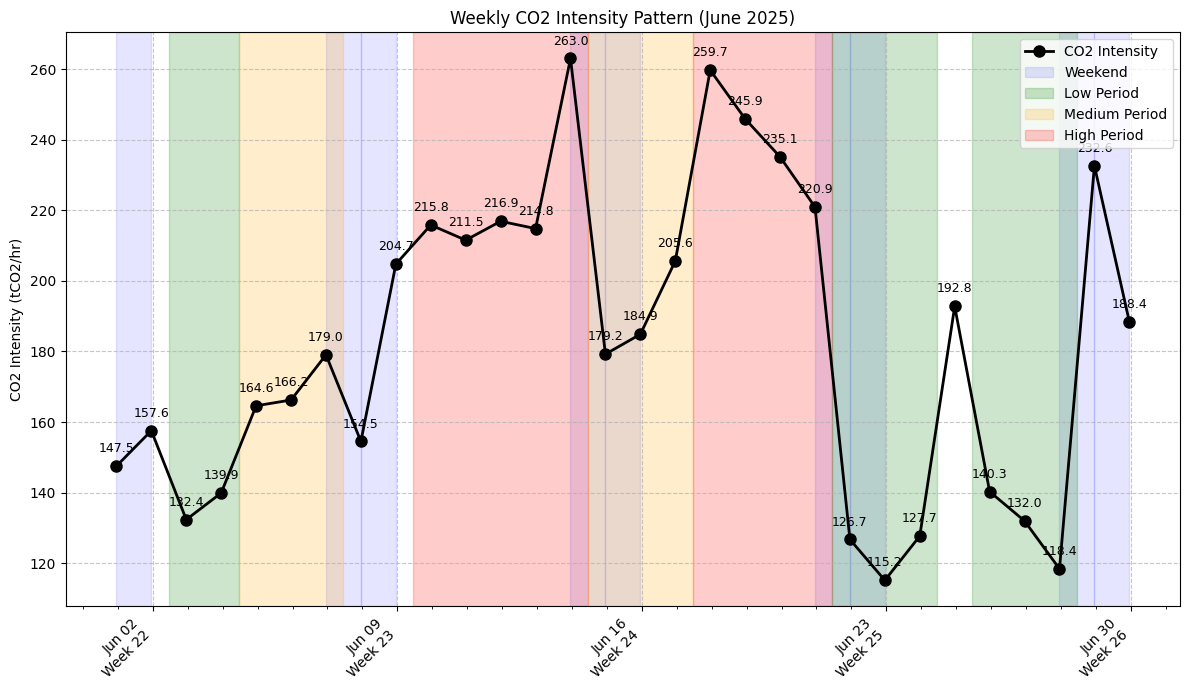

In [24]:
def highlight_weekly_patterns(df_):
    """Highlights weekly patterns in CO2 intensity data."""
    
    df = df_.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.sort_values("timestamp", inplace=True)

    # Normalize the data using Min-Max scaling
    min_val = df["value"].min()
    max_val = df["value"].max()
    df["normalized_value"] = (df["value"] - min_val) / (max_val - min_val)

    # Compute thresholds on normalized data
    p33 = np.percentile(df["normalized_value"], 33)
    p66 = np.percentile(df["normalized_value"], 66)

    # Categorize function
    def categorize(val):
        if val <= p33:
            return "Low"
        elif val <= p66:
            return "Medium"
        else:
            return "High"

    df["category"] = df["normalized_value"].apply(categorize)
    
    # Add day of week for weekly pattern analysis
    df["day_of_week"] = df["timestamp"].dt.day_name()
    df["week_number"] = df["timestamp"].dt.isocalendar().week
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot the main trend line
    ax.plot(df["timestamp"], df["value"], color="black", 
            linewidth=2, marker='o', markersize=8, label="CO2 Intensity")
    
    # Color map for categories
    color_map = {"Low": "green", "Medium": "orange", "High": "red"}
    added_to_legend = set()
    
    # Highlight weekends
    for i, row in df.iterrows():
        if row["day_of_week"] in ['Saturday', 'Sunday']:
            # Highlight the entire day
            day_start = row["timestamp"].replace(hour=0, minute=0, second=0)
            day_end = day_start + pd.Timedelta(days=1)
            ax.axvspan(day_start, day_end, color='blue', alpha=0.1, 
                       label='Weekend' if 'Weekend' not in added_to_legend else None)
            added_to_legend.add('Weekend')
    
    # Highlight consecutive periods (now considering weekly patterns)
    df["group"] = (df["category"] != df["category"].shift()).cumsum()
    
    for _, group_df in df.groupby("group"):
        category = group_df["category"].iloc[0]
        start_time = group_df["timestamp"].iloc[0]
        end_time = group_df["timestamp"].iloc[-1]
        duration_days = (end_time - start_time).days + 1
        
        # Highlight regions lasting at least 2 consecutive days
        if duration_days >= 2:
            label = f"{category} Period" if category not in added_to_legend else None
            ax.axvspan(start_time - pd.Timedelta(hours=12),
                      end_time + pd.Timedelta(hours=12),
                      color=color_map[category], alpha=0.2, label=label)
            if label:
                added_to_legend.add(category)
    
    # Format x-axis for weekly data
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Mark Mondays
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d\nWeek %W"))
    
    # Add minor ticks for each day
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    # Rotate and align x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    # Add value annotations (only for daily or weekly data)
    if len(df) < 50:  # Don't annotate if too many points
        for x, y in zip(df["timestamp"], df["value"]):
            ax.annotate(f"{y:.1f}", (x, y), textcoords="offset points", 
                       xytext=(0,10), ha='center', fontsize=9)
    
    ax.set_ylabel("CO2 Intensity (tCO2/hr)")
    title = "Weekly CO2 Intensity Pattern (June 2025)"
    if len(df) > 30:
        title += "\n(Daily Averages)"
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Call the function
highlight_weekly_patterns(data_daily)

<module 'matplotlib.pyplot' from 'c:\\Users\\nithy\\NK\\UCD\\Sem3\\SustainbleCityAI\\Backend\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

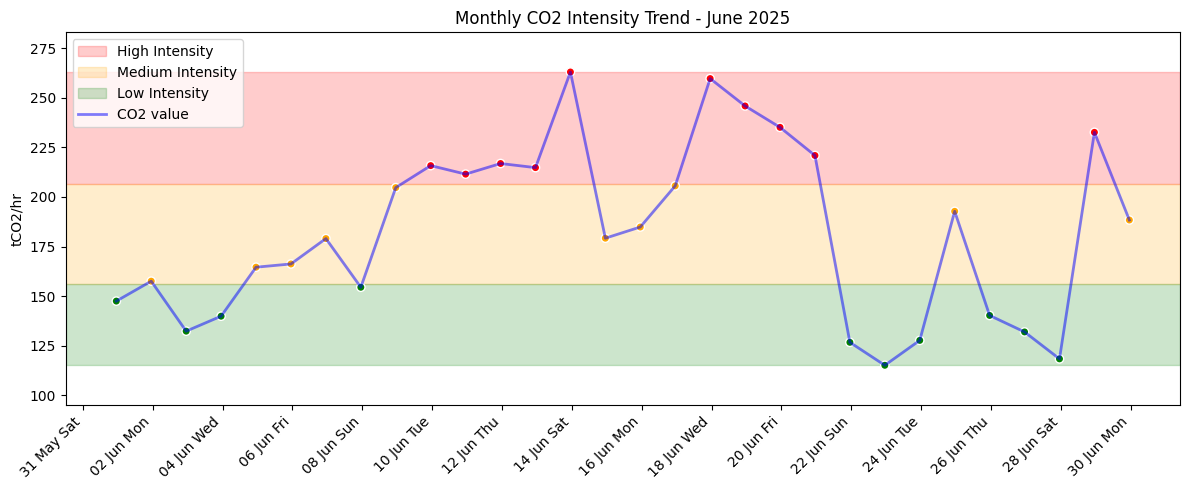

In [34]:
def co2_plot_trend_monthly(df_):
    """
    Plots the trend of CO2 intensity over a month with:
    - Background bands (green/yellow/red) based on percentiles.
    - Scatter point colors MATCHING the percentile classification.
    """
    # Prepare data
    df = df_.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.sort_values("timestamp", inplace=True)
    df.set_index("timestamp", inplace=True)

    # Calculate percentile thresholds
    low_thresh = df["value"].quantile(0.33)
    high_thresh = df["value"].quantile(0.66)

    # Assign colors based on percentiles
    colors = []
    for val in df["value"]:
        if val <= low_thresh:
            colors.append("green")  # Low intensity
        elif val <= high_thresh:
            colors.append("orange")  # Medium intensity
        else:
            colors.append("red")  # High intensity

    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # Background bands (unchanged)
    ax.axhspan(high_thresh, df["value"].max(), color="red", alpha=0.2, label="High Intensity")
    ax.axhspan(low_thresh, high_thresh, color="orange", alpha=0.2, label="Medium Intensity")
    ax.axhspan(df["value"].min(), low_thresh, color="green", alpha=0.2, label="Low Intensity")
    

    # Trend line (unchanged)
    ax.plot(df.index, df["value"], color="b", alpha=0.5, linewidth=2, label="CO2 value")

    # Scatter plot with EXPLICIT colors
    sc = ax.scatter(
        df.index, 
        df["value"], 
        c=colors,  # Use pre-assigned colors
        edgecolor="white"  # White borders for clarity
    )

    # X-axis formatting (unchanged)
    # ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Show every 2 day
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %a"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Add month/year to title
    if len(df.index) > 0:
        first_date = df.index[0]
        ax.set_title(f"Monthly CO2 Intensity Trend - {first_date.strftime('%B %Y')}")

    # Y-axis (unchanged)
    ax.set_ylabel("tCO2/hr")
    ax.set_ylim(df["value"].min() - 20, df["value"].max() + 20)

    # Legend (unchanged)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return plt

# Usage
co2_plot_trend_monthly(data_daily)